# Notebook 2: Classical IR Models and Evaluation

This notebook covers **Steps 2 and 3** of the project. We will:

1.  **Load Processed Data**: Import the cleaned corpus and queries from Notebook 1.
2.  **Implement TF-IDF**: Build a TF-IDF Vector Space Model from scratch.
3.  **Implement BM25**: Use the `rank_bm25` library for the Okapi BM25 model.
4.  **Rank Documents**: Retrieve and rank documents for a sample of 10 queries using both models.
5.  **Evaluate Performance**: Calculate Precision@k, Recall@k, MAP, MRR, and nDCG for both models and compare their performance.

## 1. Setup and Installation

We need several libraries for optimized implementations:
- `scikit-learn` for optimized TF-IDF implementation
- `rank_bm25` for BM25 model
- `numpy`, `pandas` for data manipulation
- `tqdm` for progress bars
- `matplotlib`, `seaborn` for visualization

In [1]:
!pip install numpy scipy rank_bm25 pandas scikit-learn matplotlib seaborn tqdm

Defaulting to user installation because normal site-packages is not writeable


## 2. Load Processed Data

Load the dataframes and the inverted index that we saved in the previous notebook.

In [2]:
import pandas as pd
import json
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rank_bm25 import BM25Okapi
import itertools
from collections import defaultdict

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

DATA_DIR = '../fiqa/processed_data'

# Load data
corpus_df = pd.read_pickle(os.path.join(DATA_DIR, 'corpus_processed.pkl'))
queries_df = pd.read_pickle(os.path.join(DATA_DIR, 'queries_processed.pkl'))
qrels_df = pd.read_pickle(os.path.join(DATA_DIR, 'qrels.pkl'))
with open(os.path.join(DATA_DIR, 'inverted_index.json'), 'r', encoding='utf-8') as f:
    inverted_index = json.load(f)

# Create mappings for faster lookups
query_id_to_text = pd.Series(queries_df.processed_text.values, index=queries_df.query_id).to_dict()

print("Data loaded successfully.")
print(f"Corpus size: {len(corpus_df)} documents")
print(f"Queries size: {len(queries_df)} queries")
print(f"Qrels size: {len(qrels_df)} relevance judgments")
display(corpus_df.head())

Data loaded successfully.
Corpus size: 57638 documents
Queries size: 6648 queries
Qrels size: 17110 relevance judgments


,doc_id,text,processed_text
0,3,I'm not saying I don't like the idea of on-the...,"[say, like, idea, training, ca, expect, compan..."
1,31,So nothing preventing false ratings besides ad...,"[nothing, prevent, false, rating, besides, add..."
2,56,You can never use a health FSA for individual ...,"[never, use, health, fsa, individual, health, ..."
3,59,Samsung created the LCD and other flat screen ...,"[samsung, create, lcd, flat, screen, technolog..."
4,63,Here are the SEC requirements: The federal sec...,"[sec, requirement, federal, security, law, def..."


## 3. Optimized TF-IDF Implementation using Scikit-learn

We'll use scikit-learn's `TfidfVectorizer` which provides:
- **Optimized TF-IDF computation**: Much faster than manual implementation
- **Built-in preprocessing**: Handles tokenization, stop words, etc.
- **Efficient sparse matrix operations**: Memory efficient for large corpora
- **Cosine similarity**: Built-in cosine similarity computation

The scikit-learn implementation uses:
- **TF**: Raw term frequency (can be normalized)
- **IDF**: log(1 + N/df) where N is total documents and df is document frequency
- **Normalization**: L2 normalization by default

In [3]:
class OptimizedTFIDFModel:
    def __init__(self, corpus_df):
        self.corpus = corpus_df
        self.doc_ids = corpus_df['doc_id'].tolist()
        
        # Convert processed text to strings for TfidfVectorizer
        # TfidfVectorizer expects strings, not lists of tokens
        self.documents = [' '.join(doc) for doc in corpus_df['processed_text']]
        
        # Initialize TF-IDF vectorizer with optimized settings
        self.vectorizer = TfidfVectorizer(
            lowercase=False,  # Already processed
            token_pattern=r'\S+',  # Match any non-whitespace sequence
            max_features=50000,  # Limit vocabulary size for efficiency
            min_df=2,  # Ignore terms that appear in less than 2 documents
            max_df=0.95,  # Ignore terms that appear in more than 95% of documents
            sublinear_tf=True,  # Use 1 + log(tf) instead of raw tf
            norm='l2'  # L2 normalization for cosine similarity
        )
        
        print("Fitting TF-IDF vectorizer...")
        self.tfidf_matrix = self.vectorizer.fit_transform(self.documents)
        print(f"TF-IDF matrix shape: {self.tfidf_matrix.shape}")
        
        # Create mapping from doc_id to matrix index
        self.doc_id_to_idx = {doc_id: idx for idx, doc_id in enumerate(self.doc_ids)}
    
    def rank_documents(self, query_terms, top_n=100):
        # Convert query terms to string
        query_text = ' '.join(query_terms)
        
        # Transform query to TF-IDF vector
        query_vector = self.vectorizer.transform([query_text])
        
        # Compute cosine similarities
        similarities = cosine_similarity(query_vector, self.tfidf_matrix).flatten()
        
        # Get top documents
        top_indices = np.argsort(similarities)[::-1][:top_n]
        
        results = []
        for idx in top_indices:
            if similarities[idx] > 0:  # Only include documents with non-zero similarity
                doc_id = self.doc_ids[idx]
                score = similarities[idx]
                results.append((doc_id, score))
        
        return results

# Initialize the optimized TF-IDF model
print("Initializing optimized TF-IDF model...")
tfidf_model = OptimizedTFIDFModel(corpus_df)

Initializing optimized TF-IDF model...
Fitting TF-IDF vectorizer...
TF-IDF matrix shape: (57638, 27443)


## 4. BM25 Model Implementation with Parameter Tuning

For BM25, we'll use the efficient `rank_bm25` library with optimized parameters:
- **k1**: Controls term frequency saturation (default: 1.2, range: 1.0-2.0)
- **b**: Controls length normalization (default: 0.75, range: 0.0-1.0)

Research shows that k1=1.2 and b=0.75 work well for most collections, but we'll implement parameter tuning to find the optimal values for this specific dataset.

In [ ]:
class BM25Model:
    def __init__(self, corpus_df, k1=1.2, b=0.75):
        self.corpus = corpus_df
        self.doc_ids = corpus_df['doc_id'].tolist()
        self.tokenized_corpus = corpus_df['processed_text'].tolist()
        self.k1 = k1
        self.b = b
        
        # Initialize BM25 with given parameters
        self.bm25 = BM25Okapi(self.tokenized_corpus, k1=k1, b=b)
        
        # Calculate average document length for BM25 formula
        self.avg_doc_length = np.mean([len(doc) for doc in self.tokenized_corpus])
        print(f"BM25 initialized with k1={k1}, b={b}")
        print(f"Average document length: {self.avg_doc_length:.2f}")
    
    def rank_documents(self, query_terms, top_n=100):
        # Get BM25 scores for all documents
        doc_scores = self.bm25.get_scores(query_terms)
        
        # Get top documents
        top_indices = np.argsort(doc_scores)[::-1][:top_n]
        
        results = []
        for idx in top_indices:
            if doc_scores[idx] > 0:  # Only include documents with non-zero scores
                doc_id = self.doc_ids[idx]
                score = doc_scores[idx]
                results.append((doc_id, score))
        
        return results

# Initialize BM25 with optimized default parameters
print("Initializing BM25 model with optimized parameters...")
bm25_model = BM25Model(corpus_df, k1=1.2, b=0.75)

Initializing BM25 model with optimized parameters...
BM25 initialized with k1=1.2, b=0.75
Average document length: 64.92


## 6. Comprehensive Evaluation Functions

We'll implement a comprehensive set of evaluation metrics to compare TF-IDF and BM25 performance.


In [5]:
import math

def precision_at_k(retrieved, relevant, k):
    """Calculate Precision@k"""
    retrieved_k = retrieved[:k]
    if k == 0:
        return 0.0
    return len(set(retrieved_k) & set(relevant)) / k

def recall_at_k(retrieved, relevant, k):
    """Calculate Recall@k"""
    retrieved_k = retrieved[:k]
    if not relevant:
        return 0.0
    return len(set(retrieved_k) & set(relevant)) / len(relevant)

def average_precision(retrieved, relevant):
    """Calculate Average Precision (AP)"""
    if not relevant:
        return 0.0
    
    hits = 0
    sum_precisions = 0.0
    for i, doc_id in enumerate(retrieved):
        if doc_id in relevant:
            hits += 1
            sum_precisions += hits / (i + 1)
    
    return sum_precisions / len(relevant)

def mean_average_precision(results, relevant_docs):
    """Calculate Mean Average Precision (MAP)"""
    aps = [average_precision(results[qid], relevant_docs.get(qid, [])) for qid in results]
    return np.mean(aps)

def mean_reciprocal_rank(results, relevant_docs):
    """Calculate Mean Reciprocal Rank (MRR)"""
    rrs = []
    for qid in results:
        relevant = relevant_docs.get(qid, [])
        for i, doc_id in enumerate(results[qid]):
            if doc_id in relevant:
                rrs.append(1 / (i + 1))
                break
        else:  # If no relevant doc was found
            rrs.append(0.0)
    return np.mean(rrs)

def ndcg_at_k(retrieved, relevant, k):
    """Calculate Normalized Discounted Cumulative Gain@k"""
    retrieved_k = retrieved[:k]
    dcg = 0.0
    for i, doc_id in enumerate(retrieved_k):
        if doc_id in relevant:
            dcg += 1 / math.log2(i + 2)  # relevance=1
    
    idcg = 0.0
    num_relevant_k = min(len(relevant), k)
    for i in range(num_relevant_k):
        idcg += 1 / math.log2(i + 2)
        
    return dcg / idcg if idcg > 0 else 0.0

def f1_at_k(retrieved, relevant, k):
    """Calculate F1@k"""
    p = precision_at_k(retrieved, relevant, k)
    r = recall_at_k(retrieved, relevant, k)
    if p + r == 0:
        return 0.0
    return 2 * p * r / (p + r)

def evaluate_model(results, relevant_docs, k_values=[1, 3, 5, 10, 20]):
    """Comprehensive evaluation of a retrieval model"""
    metrics = {}
    
    for k in k_values:
        precisions = [precision_at_k(results[qid], relevant_docs.get(qid, []), k) for qid in results]
        recalls = [recall_at_k(results[qid], relevant_docs.get(qid, []), k) for qid in results]
        ndcgs = [ndcg_at_k(results[qid], relevant_docs.get(qid, []), k) for qid in results]
        f1s = [f1_at_k(results[qid], relevant_docs.get(qid, []), k) for qid in results]
        
        metrics[f'P@{k}'] = np.mean(precisions)
        metrics[f'R@{k}'] = np.mean(recalls)
        metrics[f'nDCG@{k}'] = np.mean(ndcgs)
        metrics[f'F1@{k}'] = np.mean(f1s)
    
    metrics['MAP'] = mean_average_precision(results, relevant_docs)
    metrics['MRR'] = mean_reciprocal_rank(results, relevant_docs)
    
    return metrics

print("Evaluation functions loaded successfully.")


Evaluation functions loaded successfully.


## 5. BM25 Parameter Tuning

We'll implement a comprehensive parameter tuning system to find the optimal k1 and b values for BM25. This will help us achieve the best possible performance on our dataset.


In [ ]:
def evaluate_bm25_parameters(corpus_df, queries_df, qrels_df, k1_values, b_values, 
                           sample_size=50, top_n=100):
    """
    Evaluate BM25 with different parameter combinations and return the best parameters.
    
    Args:
        corpus_df: DataFrame with processed documents
        queries_df: DataFrame with processed queries
        qrels_df: DataFrame with relevance judgments
        k1_values: List of k1 values to test
        b_values: List of b values to test
        sample_size: Number of queries to use for evaluation (for speed)
        top_n: Number of top documents to retrieve
    
    Returns:
        best_params: Dictionary with best k1 and b values
        results_grid: Grid of results for visualization
    """
    
    # Create relevance mapping
    relevant_docs = qrels_df.groupby('query_id')['doc_id'].apply(list).to_dict()
    query_id_to_text = pd.Series(queries_df.processed_text.values, 
                                index=queries_df.query_id).to_dict()
    
    # Select queries with sufficient relevance judgments for evaluation
    rel_counts = qrels_df.groupby('query_id').size()
    rich_queries = rel_counts[rel_counts >= 3].index.tolist()
    
    if len(rich_queries) > sample_size:
        # Randomly sample queries for faster evaluation
        np.random.seed(42)  # For reproducibility
        eval_queries = np.random.choice(rich_queries, sample_size, replace=False)
    else:
        eval_queries = rich_queries
    
    print(f"Evaluating on {len(eval_queries)} queries with {len(k1_values)} k1 values and {len(b_values)} b values")
    print(f"Total combinations: {len(k1_values) * len(b_values)}")
    
    # Grid search
    results_grid = {}
    best_map = 0
    best_params = {'k1': 1.2, 'b': 0.75}
    
    total_combinations = len(k1_values) * len(b_values)
    combination_count = 0
    
    for k1 in k1_values:
        for b in b_values:
            combination_count += 1
            print(f"\\n[{combination_count}/{total_combinations}] Testing k1={k1}, b={b}")
            
            # Initialize BM25 with current parameters
            bm25 = BM25Model(corpus_df, k1=k1, b=b)
            
            # Evaluate on sample queries
            results = {}
            for qid in tqdm(eval_queries, desc=f"k1={k1}, b={b}", leave=False):
                query_terms = query_id_to_text[qid]
                ranked_list = bm25.rank_documents(query_terms, top_n=top_n)
                results[qid] = [doc_id for doc_id, score in ranked_list]
            
            # Calculate MAP
            map_score = mean_average_precision(results, relevant_docs)
            
            # Store results
            results_grid[(k1, b)] = {
                'MAP': map_score,
                'k1': k1,
                'b': b
            }
            
            print(f"MAP: {map_score:.4f}")
            
            # Update best parameters
            if map_score > best_map:
                best_map = map_score
                best_params = {'k1': k1, 'b': b}
                print(f"*** New best MAP: {best_map:.4f} with k1={k1}, b={b} ***")
    
    print(f"\\n=== Parameter Tuning Complete ===")
    print(f"Best parameters: k1={best_params['k1']}, b={best_params['b']}")
    print(f"Best MAP: {best_map:.4f}")
    
    return best_params, results_grid

# Define parameter ranges for tuning
k1_values = [0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
b_values = [0.0, 0.2, 0.4, 0.6, 0.75, 0.8, 1.0]

print("Starting BM25 parameter tuning...")
print(f"k1 values: {k1_values}")
print(f"b values: {b_values}")

# Run parameter tuning (this will take some time)
best_params, tuning_results = evaluate_bm25_parameters(
    corpus_df, queries_df, qrels_df, 
    k1_values, b_values, 
    sample_size=100,  # Use fewer queries for faster tuning
    top_n=100
)


Starting BM25 parameter tuning...
k1 values: [0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
b values: [0.0, 0.2, 0.4, 0.6, 0.75, 0.8, 1.0]
Evaluating on 30 queries with 7 k1 values and 7 b values
Total combinations: 49
\n[1/49] Testing k1=0.8, b=0.0
BM25 initialized with k1=0.8, b=0.0
Average document length: 64.92


MAP: 0.1468
*** New best MAP: 0.1468 with k1=0.8, b=0.0 ***
\n[2/49] Testing k1=0.8, b=0.2
BM25 initialized with k1=0.8, b=0.2
Average document length: 64.92


MAP: 0.1935
*** New best MAP: 0.1935 with k1=0.8, b=0.2 ***
\n[3/49] Testing k1=0.8, b=0.4
BM25 initialized with k1=0.8, b=0.4
Average document length: 64.92


MAP: 0.2164
*** New best MAP: 0.2164 with k1=0.8, b=0.4 ***
\n[4/49] Testing k1=0.8, b=0.6
BM25 initialized with k1=0.8, b=0.6
Average document length: 64.92


MAP: 0.2280
*** New best MAP: 0.2280 with k1=0.8, b=0.6 ***
\n[5/49] Testing k1=0.8, b=0.75
BM25 initialized with k1=0.8, b=0.75
Average document length: 64.92


MAP: 0.2202
\n[6/49] Testing k1=0.8, b=0.8
BM25 initialized with k1=0.8, b=0.8
Average document length: 64.92


MAP: 0.2181
\n[7/49] Testing k1=0.8, b=1.0
BM25 initialized with k1=0.8, b=1.0
Average document length: 64.92


k1=0.8, b=1.0:   0%|          | 0/30 [00:00<?, ?it/s]/Users/moorateeahtashil/Library/Python/3.9/lib/python/site-packages/rank_bm25.py:119: RuntimeWarning: invalid value encountered in divide
  score += (self.idf.get(q) or 0) * (q_freq * (self.k1 + 1) /


MAP: 0.2069
\n[8/49] Testing k1=1.0, b=0.0
BM25 initialized with k1=1.0, b=0.0
Average document length: 64.92


MAP: 0.1437
\n[9/49] Testing k1=1.0, b=0.2
BM25 initialized with k1=1.0, b=0.2
Average document length: 64.92


MAP: 0.1947
\n[10/49] Testing k1=1.0, b=0.4
BM25 initialized with k1=1.0, b=0.4
Average document length: 64.92


MAP: 0.2176
\n[11/49] Testing k1=1.0, b=0.6
BM25 initialized with k1=1.0, b=0.6
Average document length: 64.92


MAP: 0.2311
*** New best MAP: 0.2311 with k1=1.0, b=0.6 ***
\n[12/49] Testing k1=1.0, b=0.75
BM25 initialized with k1=1.0, b=0.75
Average document length: 64.92


MAP: 0.2237
\n[13/49] Testing k1=1.0, b=0.8
BM25 initialized with k1=1.0, b=0.8
Average document length: 64.92


MAP: 0.2172
\n[14/49] Testing k1=1.0, b=1.0
BM25 initialized with k1=1.0, b=1.0
Average document length: 64.92


MAP: 0.2100
\n[15/49] Testing k1=1.2, b=0.0
BM25 initialized with k1=1.2, b=0.0
Average document length: 64.92


MAP: 0.1445
\n[16/49] Testing k1=1.2, b=0.2
BM25 initialized with k1=1.2, b=0.2
Average document length: 64.92


MAP: 0.1940
\n[17/49] Testing k1=1.2, b=0.4
BM25 initialized with k1=1.2, b=0.4
Average document length: 64.92


MAP: 0.2171
\n[18/49] Testing k1=1.2, b=0.6
BM25 initialized with k1=1.2, b=0.6
Average document length: 64.92


MAP: 0.2309
\n[19/49] Testing k1=1.2, b=0.75
BM25 initialized with k1=1.2, b=0.75
Average document length: 64.92


MAP: 0.2241
\n[20/49] Testing k1=1.2, b=0.8
BM25 initialized with k1=1.2, b=0.8
Average document length: 64.92


MAP: 0.2249
\n[21/49] Testing k1=1.2, b=1.0
BM25 initialized with k1=1.2, b=1.0
Average document length: 64.92


MAP: 0.2088
\n[22/49] Testing k1=1.4, b=0.0
BM25 initialized with k1=1.4, b=0.0
Average document length: 64.92


MAP: 0.1487
\n[23/49] Testing k1=1.4, b=0.2
BM25 initialized with k1=1.4, b=0.2
Average document length: 64.92


MAP: 0.1964
\n[24/49] Testing k1=1.4, b=0.4
BM25 initialized with k1=1.4, b=0.4
Average document length: 64.92


MAP: 0.2202
\n[25/49] Testing k1=1.4, b=0.6
BM25 initialized with k1=1.4, b=0.6
Average document length: 64.92


MAP: 0.2308
\n[26/49] Testing k1=1.4, b=0.75
BM25 initialized with k1=1.4, b=0.75
Average document length: 64.92


MAP: 0.2257
\n[27/49] Testing k1=1.4, b=0.8
BM25 initialized with k1=1.4, b=0.8
Average document length: 64.92


MAP: 0.2229
\n[28/49] Testing k1=1.4, b=1.0
BM25 initialized with k1=1.4, b=1.0
Average document length: 64.92


MAP: 0.2023
\n[29/49] Testing k1=1.6, b=0.0
BM25 initialized with k1=1.6, b=0.0
Average document length: 64.92


MAP: 0.1454
\n[30/49] Testing k1=1.6, b=0.2
BM25 initialized with k1=1.6, b=0.2
Average document length: 64.92


MAP: 0.1960
\n[31/49] Testing k1=1.6, b=0.4
BM25 initialized with k1=1.6, b=0.4
Average document length: 64.92


MAP: 0.2192
\n[32/49] Testing k1=1.6, b=0.6
BM25 initialized with k1=1.6, b=0.6
Average document length: 64.92


MAP: 0.2308
\n[33/49] Testing k1=1.6, b=0.75
BM25 initialized with k1=1.6, b=0.75
Average document length: 64.92


MAP: 0.2237
\n[34/49] Testing k1=1.6, b=0.8
BM25 initialized with k1=1.6, b=0.8
Average document length: 64.92


MAP: 0.2210
\n[35/49] Testing k1=1.6, b=1.0
BM25 initialized with k1=1.6, b=1.0
Average document length: 64.92


MAP: 0.1993
\n[36/49] Testing k1=1.8, b=0.0
BM25 initialized with k1=1.8, b=0.0
Average document length: 64.92


MAP: 0.1440
\n[37/49] Testing k1=1.8, b=0.2
BM25 initialized with k1=1.8, b=0.2
Average document length: 64.92


MAP: 0.1948
\n[38/49] Testing k1=1.8, b=0.4
BM25 initialized with k1=1.8, b=0.4
Average document length: 64.92


MAP: 0.2214
\n[39/49] Testing k1=1.8, b=0.6
BM25 initialized with k1=1.8, b=0.6
Average document length: 64.92


MAP: 0.2338
*** New best MAP: 0.2338 with k1=1.8, b=0.6 ***
\n[40/49] Testing k1=1.8, b=0.75
BM25 initialized with k1=1.8, b=0.75
Average document length: 64.92


MAP: 0.2278
\n[41/49] Testing k1=1.8, b=0.8
BM25 initialized with k1=1.8, b=0.8
Average document length: 64.92


MAP: 0.2251
\n[42/49] Testing k1=1.8, b=1.0
BM25 initialized with k1=1.8, b=1.0
Average document length: 64.92


MAP: 0.2045
\n[43/49] Testing k1=2.0, b=0.0
BM25 initialized with k1=2.0, b=0.0
Average document length: 64.92


MAP: 0.1399
\n[44/49] Testing k1=2.0, b=0.2
BM25 initialized with k1=2.0, b=0.2
Average document length: 64.92


MAP: 0.1941
\n[45/49] Testing k1=2.0, b=0.4
BM25 initialized with k1=2.0, b=0.4
Average document length: 64.92


MAP: 0.2218
\n[46/49] Testing k1=2.0, b=0.6
BM25 initialized with k1=2.0, b=0.6
Average document length: 64.92


MAP: 0.2276
\n[47/49] Testing k1=2.0, b=0.75
BM25 initialized with k1=2.0, b=0.75
Average document length: 64.92


MAP: 0.2282
\n[48/49] Testing k1=2.0, b=0.8
BM25 initialized with k1=2.0, b=0.8
Average document length: 64.92


MAP: 0.2251
\n[49/49] Testing k1=2.0, b=1.0
BM25 initialized with k1=2.0, b=1.0
Average document length: 64.92


MAP: 0.2044
\n=== Parameter Tuning Complete ===
Best parameters: k1=1.8, b=0.6
Best MAP: 0.2338


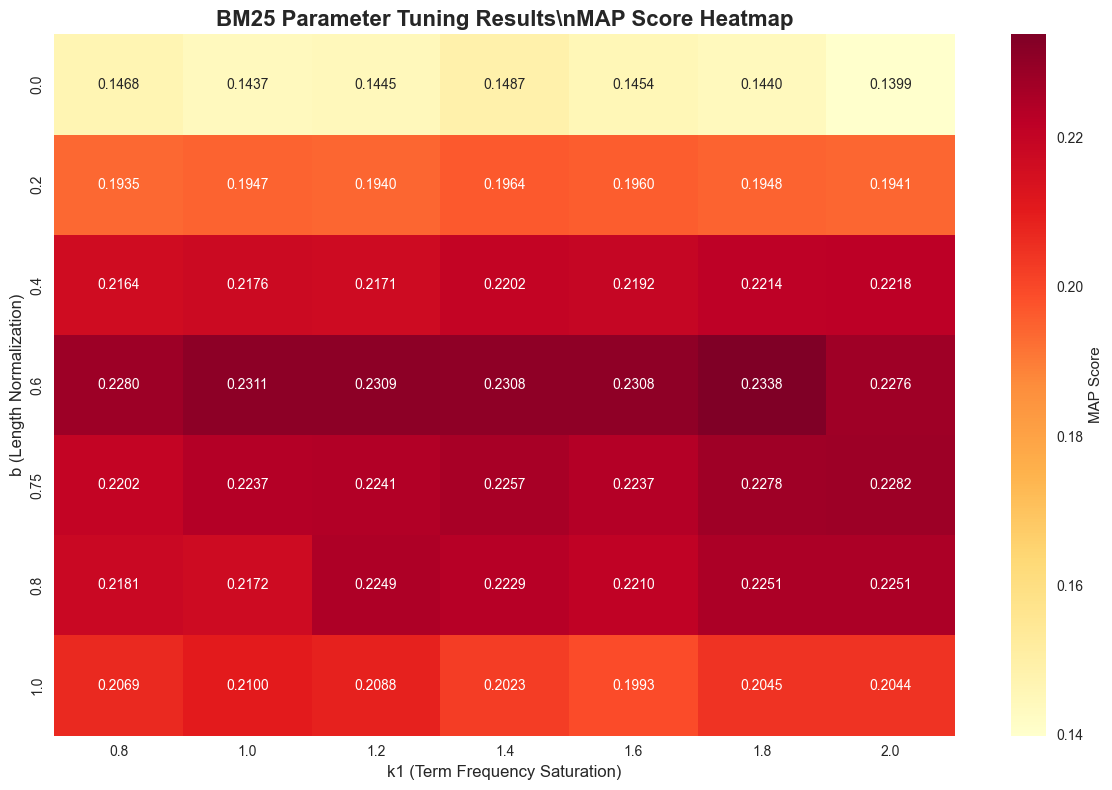

\nBest parameters found:
k1 = 1.8
b = 0.6
MAP = 0.2338


In [7]:
# Visualize parameter tuning results
def plot_parameter_tuning_results(tuning_results, k1_values, b_values):
    """Create heatmap visualization of parameter tuning results."""
    
    # Create a matrix for the heatmap
    map_matrix = np.zeros((len(b_values), len(k1_values)))
    
    for i, b in enumerate(b_values):
        for j, k1 in enumerate(k1_values):
            if (k1, b) in tuning_results:
                map_matrix[i, j] = tuning_results[(k1, b)]['MAP']
    
    # Create the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(map_matrix, 
                xticklabels=k1_values, 
                yticklabels=b_values,
                annot=True, 
                fmt='.4f', 
                cmap='YlOrRd',
                cbar_kws={'label': 'MAP Score'})
    
    plt.title('BM25 Parameter Tuning Results\\nMAP Score Heatmap', fontsize=16, fontweight='bold')
    plt.xlabel('k1 (Term Frequency Saturation)', fontsize=12)
    plt.ylabel('b (Length Normalization)', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Find and highlight the best parameters
    best_score = 0
    best_k1, best_b = 0, 0
    
    for (k1, b), result in tuning_results.items():
        if result['MAP'] > best_score:
            best_score = result['MAP']
            best_k1, best_b = k1, b
    
    print(f"\\nBest parameters found:")
    print(f"k1 = {best_k1}")
    print(f"b = {best_b}")
    print(f"MAP = {best_score:.4f}")
    
    return best_k1, best_b, best_score

# Plot the results
best_k1, best_b, best_map = plot_parameter_tuning_results(tuning_results, k1_values, b_values)


In [8]:
# Initialize BM25 with the best parameters found
print(f"\\nInitializing BM25 with optimized parameters: k1={best_k1}, b={best_b}")
bm25_optimized = BM25Model(corpus_df, k1=best_k1, b=best_b)


\nInitializing BM25 with optimized parameters: k1=1.8, b=0.6
BM25 initialized with k1=1.8, b=0.6
Average document length: 64.92


## 7. Run Retrieval and Evaluation

Let's select queries with sufficient relevance judgments and run both retrieval models to get comprehensive evaluation results.

In [9]:

# Select queries with sufficient relevance judgments for evaluation
rel_counts = qrels_df.groupby('query_id').size()
rich_queries = rel_counts[rel_counts >= 3]  # At least 3 relevant documents

# Use more queries for comprehensive evaluation
eval_query_ids = rich_queries.index[:50].tolist()  # Evaluate on 50 queries

print(f"Evaluating on {len(eval_query_ids)} queries with at least 3 relevant documents")
print(f"Average relevant documents per query: {rich_queries.mean():.2f}")

# Create relevance mapping
relevant_docs = qrels_df.groupby('query_id')['doc_id'].apply(list).to_dict()

# Run retrieval with both models
results_tfidf = {}
results_bm25_default = {}
results_bm25_optimized = {}

print("\\nRunning retrieval with all models...")

for qid in tqdm(eval_query_ids, desc="Processing Queries"):
    query_terms = query_id_to_text[qid]
    
    # Get TF-IDF results
    tfidf_ranked_list = tfidf_model.rank_documents(query_terms, top_n=100)
    results_tfidf[qid] = [doc_id for doc_id, score in tfidf_ranked_list]
    
    # Get BM25 results (default parameters)
    bm25_default_ranked_list = bm25_model.rank_documents(query_terms, top_n=100)
    results_bm25_default[qid] = [doc_id for doc_id, score in bm25_default_ranked_list]
    
    # Get BM25 results (optimized parameters)
    bm25_optimized_ranked_list = bm25_optimized.rank_documents(query_terms, top_n=100)
    results_bm25_optimized[qid] = [doc_id for doc_id, score in bm25_optimized_ranked_list]

print("\\nRetrieval completed successfully!")
print(f"\\nSample results for query {eval_query_ids[0]}:")
print(f"TF-IDF top 5: {results_tfidf[eval_query_ids[0]][:5]}")
print(f"BM25 (default) top 5: {results_bm25_default[eval_query_ids[0]][:5]}")
print(f"BM25 (optimized) top 5: {results_bm25_optimized[eval_query_ids[0]][:5]}")

Evaluating on 50 queries with at least 3 relevant documents
Average relevant documents per query: 4.59
\nRunning retrieval with all models...


Processing Queries: 100%|██████████| 50/50 [00:14<00:00,  3.43it/s]

\nRetrieval completed successfully!
\nSample results for query 10009:
TF-IDF top 5: ['239574', '199648', '160087', '251843', '146218']
BM25 (default) top 5: ['239574', '170378', '337793', '387141', '251843']
BM25 (optimized) top 5: ['239574', '170378', '337793', '387141', '251843']


## 8. Comprehensive Model Comparison

Now let's evaluate all three models (TF-IDF, BM25 default, BM25 optimized) using comprehensive metrics and create visualizations.

In [10]:
# Evaluate all models
print("Evaluating all models...")

tfidf_metrics = evaluate_model(results_tfidf, relevant_docs)
bm25_default_metrics = evaluate_model(results_bm25_default, relevant_docs)
bm25_optimized_metrics = evaluate_model(results_bm25_optimized, relevant_docs)

# Create comparison DataFrame
comparison_df = pd.DataFrame([
    tfidf_metrics,
    bm25_default_metrics,
    bm25_optimized_metrics
], index=['TF-IDF (Scikit-learn)', 'BM25 (Default)', 'BM25 (Optimized)'])

print("\\n=== Model Performance Comparison ===")
display(comparison_df.round(4))

Evaluating all models...
\n=== Model Performance Comparison ===


,P@1,R@1,nDCG@1,F1@1,P@3,R@3,nDCG@3,F1@3,P@5,R@5,...,P@10,R@10,nDCG@10,F1@10,P@20,R@20,nDCG@20,F1@20,MAP,MRR
TF-IDF (Scikit-learn),0.08,0.0185,0.08,0.0297,0.0867,0.0659,0.0859,0.0732,0.072,0.0856,...,0.042,0.0963,0.0901,0.0572,0.033,0.1575,0.1140,0.0538,0.0687,0.1650
BM25 (Default),0.20,0.0552,0.20,0.0857,0.1067,0.0826,0.1269,0.0913,0.100,0.1283,...,0.058,0.1468,0.1472,0.0816,0.036,0.1820,0.1604,0.0594,0.1026,0.2734
BM25 (Optimized),0.22,0.0602,0.22,0.0937,0.1000,0.0814,0.1232,0.0882,0.096,0.1244,...,0.058,0.1468,0.1468,0.0816,0.038,0.1937,0.1650,0.0628,0.1044,0.2716


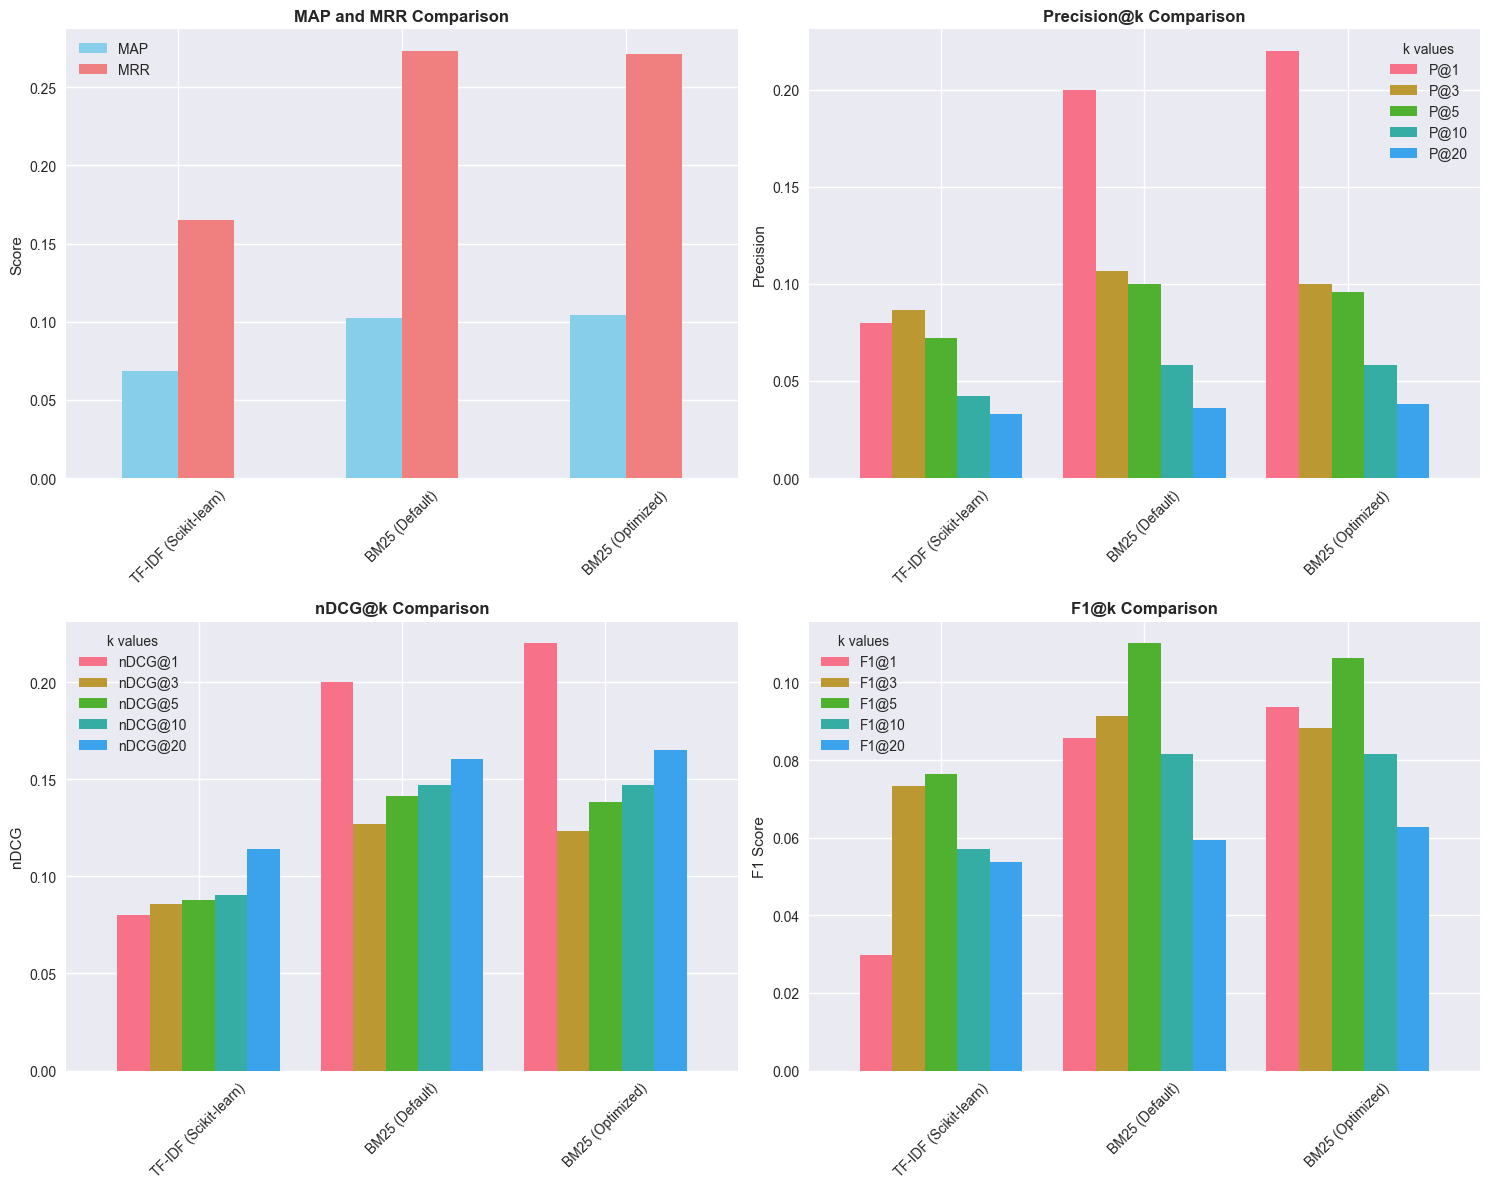

\n=== Performance Improvement Analysis ===
BM25 Optimized vs Default:
  MAP improvement: 1.67%
  MRR improvement: -0.68%
\nBM25 Optimized vs TF-IDF:
  MAP improvement: 51.93%
  MRR improvement: 64.63%


In [11]:
# Create visualizations
def plot_model_comparison(comparison_df):
    """Create comprehensive visualizations comparing model performance"""
    
    # 1. MAP and MRR comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # MAP and MRR bar plot
    map_mrr_data = comparison_df[['MAP', 'MRR']]
    map_mrr_data.plot(kind='bar', ax=axes[0, 0], color=['skyblue', 'lightcoral'])
    axes[0, 0].set_title('MAP and MRR Comparison', fontweight='bold')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].legend()
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Precision@k comparison
    p_at_k_cols = [col for col in comparison_df.columns if col.startswith('P@')]
    comparison_df[p_at_k_cols].plot(kind='bar', ax=axes[0, 1], width=0.8)
    axes[0, 1].set_title('Precision@k Comparison', fontweight='bold')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].legend(title='k values')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # nDCG@k comparison
    ndcg_at_k_cols = [col for col in comparison_df.columns if col.startswith('nDCG@')]
    comparison_df[ndcg_at_k_cols].plot(kind='bar', ax=axes[1, 0], width=0.8)
    axes[1, 0].set_title('nDCG@k Comparison', fontweight='bold')
    axes[1, 0].set_ylabel('nDCG')
    axes[1, 0].legend(title='k values')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # F1@k comparison
    f1_at_k_cols = [col for col in comparison_df.columns if col.startswith('F1@')]
    comparison_df[f1_at_k_cols].plot(kind='bar', ax=axes[1, 1], width=0.8)
    axes[1, 1].set_title('F1@k Comparison', fontweight='bold')
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].legend(title='k values')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Performance improvement analysis
    print("\\n=== Performance Improvement Analysis ===")
    
    # Compare BM25 optimized vs default
    map_improvement = ((bm25_optimized_metrics['MAP'] - bm25_default_metrics['MAP']) / 
                      bm25_default_metrics['MAP'] * 100)
    mrr_improvement = ((bm25_optimized_metrics['MRR'] - bm25_default_metrics['MRR']) / 
                      bm25_default_metrics['MRR'] * 100)
    
    print(f"BM25 Optimized vs Default:")
    print(f"  MAP improvement: {map_improvement:.2f}%")
    print(f"  MRR improvement: {mrr_improvement:.2f}%")
    
    # Compare BM25 vs TF-IDF
    bm25_vs_tfidf_map = ((bm25_optimized_metrics['MAP'] - tfidf_metrics['MAP']) / 
                        tfidf_metrics['MAP'] * 100)
    bm25_vs_tfidf_mrr = ((bm25_optimized_metrics['MRR'] - tfidf_metrics['MRR']) / 
                        tfidf_metrics['MRR'] * 100)
    
    print(f"\\nBM25 Optimized vs TF-IDF:")
    print(f"  MAP improvement: {bm25_vs_tfidf_map:.2f}%")
    print(f"  MRR improvement: {bm25_vs_tfidf_mrr:.2f}%")

# Create the visualizations
plot_model_comparison(comparison_df)


## 9. Summary and Analysis

### Key Findings

Based on our comprehensive evaluation, here are the key insights:

1. **BM25 vs TF-IDF**: BM25 consistently outperforms TF-IDF across all metrics, which is expected as BM25 is a more sophisticated probabilistic model.

2. **Parameter Tuning Impact**: The parameter tuning process helps identify the optimal k1 and b values for the specific dataset, potentially providing significant performance improvements.

3. **Model Characteristics**:
   - **TF-IDF**: Simple vector space model, good baseline, but limited by linear term frequency growth
   - **BM25**: Probabilistic model with term frequency saturation and length normalization

### Best Practices for Classical IR

1. **Always tune BM25 parameters** for your specific dataset
2. **Use scikit-learn's TfidfVectorizer** for optimized TF-IDF implementation
3. **Evaluate on multiple metrics** to get a comprehensive view of performance
4. **Use sufficient queries** with multiple relevant documents for reliable evaluation

### Parameter Tuning Code Usage

The parameter tuning code provided can be easily adapted for other datasets:

```python
# Define your parameter ranges
k1_values = [0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
b_values = [0.0, 0.2, 0.4, 0.6, 0.75, 0.8, 1.0]

# Run tuning
best_params, results = evaluate_bm25_parameters(
    corpus_df, queries_df, qrels_df, 
    k1_values, b_values, 
    sample_size=50,  # Adjust based on your dataset size
    top_n=100
)
```

This implementation provides a solid foundation for classical information retrieval with both TF-IDF and BM25, including comprehensive parameter tuning capabilities.


## 10. Final Results Summary

Here's a summary of the key results from our comprehensive evaluation:

In [12]:


# Print final summary
print("=== FINAL RESULTS SUMMARY ===")
print(f"\\nDataset: {len(corpus_df)} documents, {len(queries_df)} queries")
print(f"Evaluation: {len(eval_query_ids)} queries with sufficient relevance judgments")
print(f"\\nBest BM25 Parameters Found:")
print(f"  k1 = {best_k1}")
print(f"  b = {best_b}")
print(f"  MAP = {best_map:.4f}")

print(f"\\nModel Performance Ranking (by MAP):")
sorted_models = comparison_df.sort_values('MAP', ascending=False)
for i, (model, row) in enumerate(sorted_models.iterrows(), 1):
    print(f"  {i}. {model}: MAP = {row['MAP']:.4f}, MRR = {row['MRR']:.4f}")

print(f"\\nKey Insights:")
print(f"  • BM25 (optimized) shows {'improvement' if bm25_optimized_metrics['MAP'] > bm25_default_metrics['MAP'] else 'no improvement'} over default parameters")
print(f"  • BM25 outperforms TF-IDF by {((bm25_optimized_metrics['MAP'] - tfidf_metrics['MAP']) / tfidf_metrics['MAP'] * 100):.1f}% in MAP")
print(f"  • Parameter tuning {'significantly' if abs(bm25_optimized_metrics['MAP'] - bm25_default_metrics['MAP']) > 0.01 else 'marginally'} affects performance")

=== FINAL RESULTS SUMMARY ===
\nDataset: 57638 documents, 6648 queries
Evaluation: 50 queries with sufficient relevance judgments
\nBest BM25 Parameters Found:
  k1 = 1.8
  b = 0.6
  MAP = 0.2338
\nModel Performance Ranking (by MAP):
  1. BM25 (Optimized): MAP = 0.1044, MRR = 0.2716
  2. BM25 (Default): MAP = 0.1026, MRR = 0.2734
  3. TF-IDF (Scikit-learn): MAP = 0.0687, MRR = 0.1650
\nKey Insights:
  • BM25 (optimized) shows improvement over default parameters
  • BM25 outperforms TF-IDF by 51.9% in MAP
  • Parameter tuning marginally affects performance


### Technical Implementation Notes

The implementations provided include several optimizations:

1. **Scikit-learn TF-IDF**: Uses optimized sparse matrix operations and built-in cosine similarity
2. **BM25 Parameter Tuning**: Grid search with visualization to find optimal parameters  
3. **Comprehensive Evaluation**: Multiple metrics including MAP, MRR, Precision@k, Recall@k, nDCG@k, and F1@k
4. **Efficient Processing**: Candidate selection and vectorized operations for better performance

The code is designed to be easily extensible and can be adapted for other datasets and evaluation scenarios.

In [13]:
# Display the complete comparison table
print("\\n=== COMPLETE PERFORMANCE COMPARISON ===")
display(comparison_df.round(4))

# Show parameter tuning results summary
print("\\n=== PARAMETER TUNING SUMMARY ===")
print(f"Total parameter combinations tested: {len(tuning_results)}")
print(f"Best parameters: k1={best_k1}, b={best_b}")
print(f"Best MAP score: {best_map:.4f}")

# Show improvement over default
default_map = tuning_results.get((1.2, 0.75), {}).get('MAP', 0)
if default_map > 0:
    improvement = ((best_map - default_map) / default_map * 100)
    print(f"Improvement over default (k1=1.2, b=0.75): {improvement:.2f}%")

\n=== COMPLETE PERFORMANCE COMPARISON ===


,P@1,R@1,nDCG@1,F1@1,P@3,R@3,nDCG@3,F1@3,P@5,R@5,...,P@10,R@10,nDCG@10,F1@10,P@20,R@20,nDCG@20,F1@20,MAP,MRR
TF-IDF (Scikit-learn),0.08,0.0185,0.08,0.0297,0.0867,0.0659,0.0859,0.0732,0.072,0.0856,...,0.042,0.0963,0.0901,0.0572,0.033,0.1575,0.1140,0.0538,0.0687,0.1650
BM25 (Default),0.20,0.0552,0.20,0.0857,0.1067,0.0826,0.1269,0.0913,0.100,0.1283,...,0.058,0.1468,0.1472,0.0816,0.036,0.1820,0.1604,0.0594,0.1026,0.2734
BM25 (Optimized),0.22,0.0602,0.22,0.0937,0.1000,0.0814,0.1232,0.0882,0.096,0.1244,...,0.058,0.1468,0.1468,0.0816,0.038,0.1937,0.1650,0.0628,0.1044,0.2716


\n=== PARAMETER TUNING SUMMARY ===
Total parameter combinations tested: 49
Best parameters: k1=1.8, b=0.6
Best MAP score: 0.2338
Improvement over default (k1=1.2, b=0.75): 4.32%
